In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Corrected raw path (no trailing backslash)
base_path = r"C:\Users\Administrator\Downloads\Python\Python_Data_Project\turbofan-rul-prediction\CMAPSSData\data\raw"

# File paths
train_path = base_path + r"\train_FD001.txt"
test_path  = base_path + r"\test_FD001.txt"
rul_path   = base_path + r"\RUL_FD001.txt"

# Column names: 1 unit + 1 cycle + 3 op settings + 21 sensors = 26 total
column_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Load data
train_df = pd.read_csv(train_path, sep="\s+", header=None, names=column_names)
test_df = pd.read_csv(test_path, sep="\s+", header=None, names=column_names)
rul_df = pd.read_csv(rul_path, sep="\s+", header=None, names=['RUL'])

# Confirm load
print("✅ Loaded:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"RUL shape:   {rul_df.shape}")



✅ Loaded:
Train shape: (20631, 26)
Test shape:  (13096, 26)
RUL shape:   (100, 1)


In [2]:
# 🧮 Add RUL to Training Set

# Compute the max cycle for each engine
rul_train = train_df.groupby('unit')['cycle'].max().reset_index()
rul_train.columns = ['unit', 'max_cycle']

# Merge to calculate RUL
train_df = train_df.merge(rul_train, on='unit', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Preview
train_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [3]:
#🧮 Add RUL to Test Set

# Compute the max cycle per engine in test set
rul_test = test_df.groupby('unit')['cycle'].max().reset_index()
rul_test.columns = ['unit', 'max_cycle']

# Attach provided RUL values (from RUL_FD001.txt)
rul_df['unit'] = rul_test['unit']
rul_test = rul_test.merge(rul_df, on='unit', how='left')

# Merge with test_df and compute RUL for each row
test_df = test_df.merge(rul_test, on='unit', how='left')
test_df['RUL'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['cycle'])
test_df.drop('max_cycle', axis=1, inplace=True)

# Preview
test_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


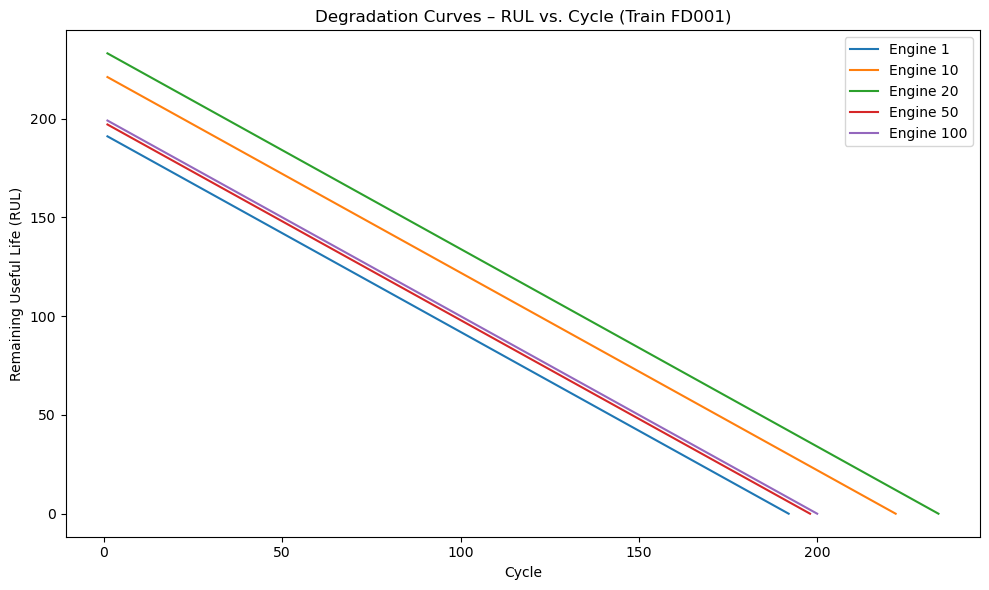

In [4]:
# 📊 Quick Visualization: Sample Degradation Curves

engines_to_plot = [1, 10, 20, 50, 100]

plt.figure(figsize=(10, 6))
for uid in engines_to_plot:
    df = train_df[train_df['unit'] == uid]
    plt.plot(df['cycle'], df['RUL'], label=f"Engine {uid}")

plt.title("Degradation Curves – RUL vs. Cycle (Train FD001)")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# ✅ STEP 2.1: Sensor Selection (Remove Flat/Noisy Columns)
#Some sensors don’t change much and are not helpful. Let’s find them.

# View the variance of each sensor
sensor_cols = [col for col in train_df.columns if 'sensor_' in col]
train_df[sensor_cols].describe().T[['mean', 'std']].sort_values('std')

,mean,std
sensor_19,100.000000,0.000000e+00
sensor_18,2388.000000,0.000000e+00
sensor_16,0.030000,1.556432e-14
sensor_10,1.300000,4.660829e-13
sensor_5,14.620000,3.394700e-12
sensor_1,518.670000,6.537152e-11
sensor_6,21.609803,1.388985e-03
sensor_15,8.442146,3.750504e-02
sensor_8,2388.096652,7.098548e-02
sensor_13,2388.096152,7.191892e-02


In [6]:
# From prior studies on C-MAPSS, commonly retained sensors for FD001 are:

selected_sensors = [
    'sensor_2', 'sensor_3', 'sensor_4',
    'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_13',
    'sensor_14', 'sensor_15', 'sensor_17',
    'sensor_20', 'sensor_21'
]

In [7]:
# You can also include the 3 operational settings if desired:

features = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + selected_sensors

In [8]:
# ✅ STEP 2.2: Normalize (Standard Scaling)
# This is essential if you're using models that are sensitive to scale (e.g., regression, neural nets).

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
scaler.fit(train_df[features])

# Transform train and test
train_df[features] = scaler.transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

In [9]:
# ✅ STEP 2.3: Create Feature Matrix (X) and Target (y)
# This will get your data ready for traditional models (Random Forest, XGBoost, etc.)

X_train = train_df[features]
y_train = train_df['RUL']

X_test = test_df[features]
y_test = test_df['RUL']


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reuse scaled features from preprocessing
features = ['op_setting_1', 'op_setting_2', 'op_setting_3',
            'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
            'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12',
            'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
            'sensor_20', 'sensor_21']

X_train = train_df[features]
y_train = train_df['RUL']

X_test = test_df[features]
y_test = test_df['RUL']


In [11]:
#🎯 Train the Random Forest

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [12]:
#📊 Evaluate Model Performance

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def print_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📈 {name} Performance:")
    print(f"  - MAE:  {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")

print_metrics(y_test, y_pred, name="Random Forest")


📈 Random Forest Performance:
  - MAE:  34.51
  - RMSE: 45.95


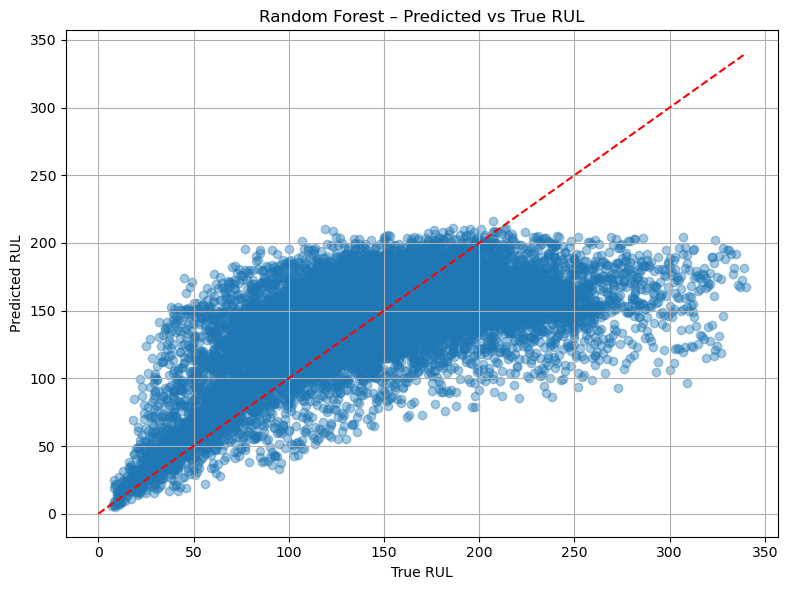

In [13]:
#📈 Plot Predicted vs True RUL

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest – Predicted vs True RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

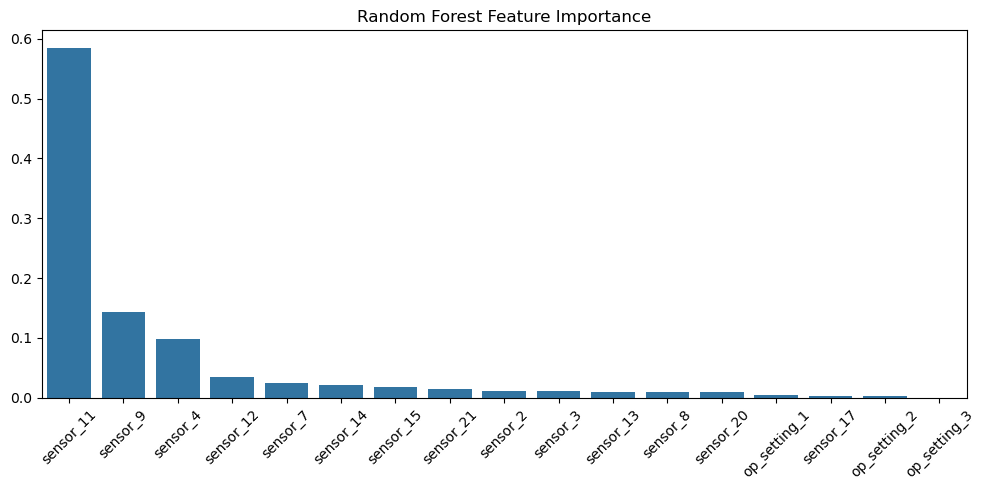

In [14]:
# 📊 Feature Importance (Optional)

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=np.array(features)[sorted_idx], y=importances[sorted_idx])
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [15]:
"""
✅ Step 2: Train an XGBoost Regressor
This will give you:

Better performance via boosting

Access to feature importance, SHAP values, etc.

Better generalization and flexibility compared to Random Forest
"""

'\n✅ Step 2: Train an XGBoost Regressor\nThis will give you:\n\nBetter performance via boosting\n\nAccess to feature importance, SHAP values, etc.\n\nBetter generalization and flexibility compared to Random Forest\n'

In [16]:
# 📄 Code for XGBoost RUL Prediction

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare DMatrix (optional but faster for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=200)



In [17]:
# 🔍 Predict and Evaluate

y_pred_xgb = xgb_model.predict(dtest)

def print_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"📈 {name} Performance:")
    print(f"  - MAE:  {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")

print_metrics(y_test, y_pred_xgb, name="XGBoost")

📈 XGBoost Performance:
  - MAE:  35.30
  - RMSE: 46.85


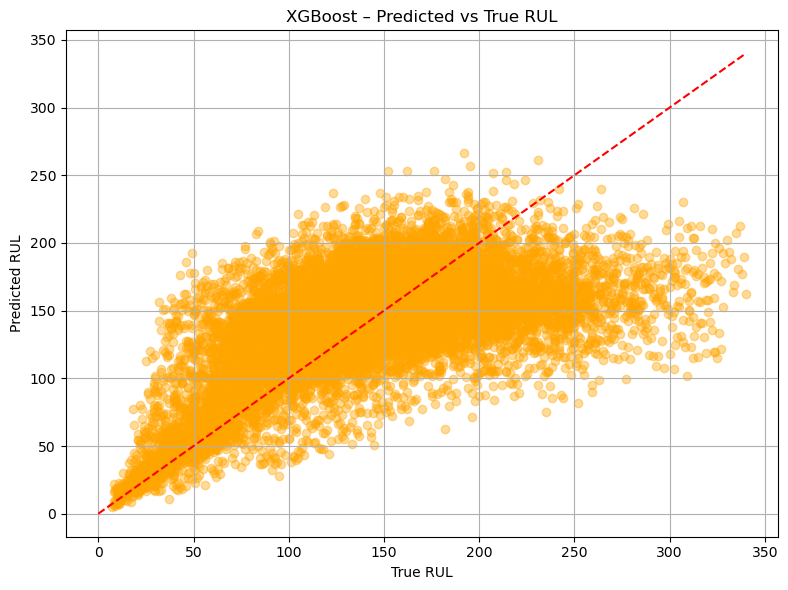

In [18]:
# 📊 Plot Predicted vs True RUL

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.4, color='orange')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("XGBoost – Predicted vs True RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

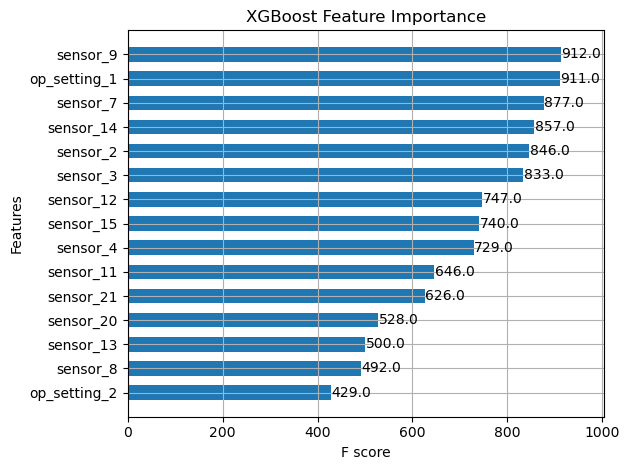

In [19]:
# 📈 (Optional) Feature Importance

xgb.plot_importance(xgb_model, height=0.6, max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [20]:
"""

✅ Step 3: Train an LSTM (or CNN) for RUL Prediction
This step models the temporal dependencies of engine degradation using sequential data — something tree models cannot capture.

🧠 Why LSTM?
Learns patterns over time (sequential degradation)

Especially effective when RUL isn't just a function of the current cycle, but the trajectory of sensor readings

Widely used in real-world Prognostics and Health Management (PHM)

"""

"\n\n✅ Step 3: Train an LSTM (or CNN) for RUL Prediction\nThis step models the temporal dependencies of engine degradation using sequential data — something tree models cannot capture.\n\n🧠 Why LSTM?\nLearns patterns over time (sequential degradation)\n\nEspecially effective when RUL isn't just a function of the current cycle, but the trajectory of sensor readings\n\nWidely used in real-world Prognostics and Health Management (PHM)\n\n"

In [21]:
"""

🔧 Step 3.1: Prepare Data for LSTM
LSTM needs sequences like:

[ [sensor_1_t-30, ..., sensor_n_t-30],
  [sensor_1_t-29, ..., sensor_n_t-29],
  ...
  [sensor_1_t, ..., sensor_n_t] ]

We’ll use:

A window size (e.g. 30 timesteps)

A sliding window to extract sequences and corresponding RUL labels

"""

'\n\n🔧 Step 3.1: Prepare Data for LSTM\nLSTM needs sequences like:\n\n[ [sensor_1_t-30, ..., sensor_n_t-30],\n  [sensor_1_t-29, ..., sensor_n_t-29],\n  ...\n  [sensor_1_t, ..., sensor_n_t] ]\n\nWe’ll use:\n\nA window size (e.g. 30 timesteps)\n\nA sliding window to extract sequences and corresponding RUL labels\n\n'

In [22]:
# ✅ Code: Sequence Generator Function

def generate_sequences(df, sequence_length=30, features=None):
    X, y = [], []
    engines = df['unit'].unique()

    for unit in engines:
        unit_df = df[df['unit'] == unit].reset_index(drop=True)

        for i in range(len(unit_df) - sequence_length):
            seq_x = unit_df.loc[i:i+sequence_length-1, features].values
            seq_y = unit_df.loc[i+sequence_length, 'RUL']
            X.append(seq_x)
            y.append(seq_y)

    return np.array(X), np.array(y)

In [23]:
# ✅ Build LSTM Dataset

# Set sequence length
seq_length = 30

# Reuse features list from earlier
X_train_seq, y_train_seq = generate_sequences(train_df, sequence_length=seq_length, features=features)
X_test_seq, y_test_seq = generate_sequences(test_df, sequence_length=seq_length, features=features)

print(f"✅ X_train_seq shape: {X_train_seq.shape}")  # (num_samples, 30, num_features)
print(f"✅ y_train_seq shape: {y_train_seq.shape}")  # (num_samples,)

✅ X_train_seq shape: (17631, 30, 17)
✅ y_train_seq shape: (17631,)


In [24]:
# 🧱 1. Convert NumPy Sequences to PyTorch Datasets

import torch
from torch.utils.data import Dataset, DataLoader

class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap into DataLoader
batch_size = 64

train_dataset = RULDataset(X_train_seq, y_train_seq)
test_dataset = RULDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# 🧠 2. Define the LSTM Model

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)        # Output shape: (batch, seq_len, hidden)
        last_time_step = lstm_out[:, -1]  # Take last time step
        out = self.fc(last_time_step)     # Final prediction
        return out.squeeze()

In [26]:
# 🚀 3. Train the LSTM Model

# Model setup
input_size = X_train_seq.shape[2]
model = LSTMModel(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20 | Train Loss: 10328.1095
Epoch 2/20 | Train Loss: 7713.9268
Epoch 3/20 | Train Loss: 5887.8794
Epoch 4/20 | Train Loss: 4549.2090
Epoch 5/20 | Train Loss: 3559.0874
Epoch 6/20 | Train Loss: 2832.2364
Epoch 7/20 | Train Loss: 2298.1770
Epoch 8/20 | Train Loss: 1904.9272
Epoch 9/20 | Train Loss: 1610.4205
Epoch 10/20 | Train Loss: 1407.8829
Epoch 11/20 | Train Loss: 1230.1218
Epoch 12/20 | Train Loss: 1102.7654
Epoch 13/20 | Train Loss: 1007.5644
Epoch 14/20 | Train Loss: 920.7079
Epoch 15/20 | Train Loss: 844.8688
Epoch 16/20 | Train Loss: 799.6151
Epoch 17/20 | Train Loss: 748.7465
Epoch 18/20 | Train Loss: 699.3598
Epoch 19/20 | Train Loss: 652.2843
Epoch 20/20 | Train Loss: 613.4202


In [27]:
# 📈 4. Evaluate the Model

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model.eval()
preds = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actuals.append(batch_y.numpy())

y_pred_lstm = np.concatenate(preds)
y_true_lstm = np.concatenate(actuals)

mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
print(f"📊 LSTM Test MAE: {mae:.2f} | RMSE: {rmse:.2f}")

📊 LSTM Test MAE: 29.53 | RMSE: 40.14


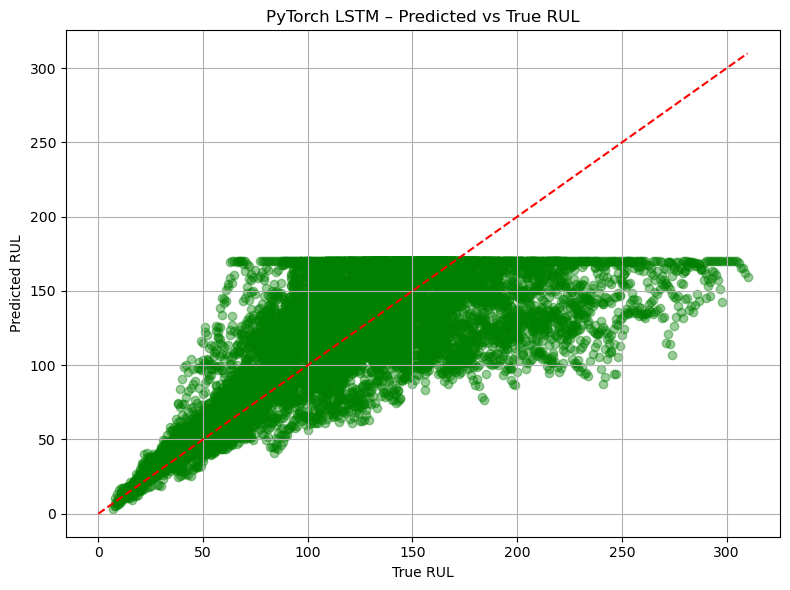

In [28]:
# 📊 5. Plot Predicted vs. True RUL

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_lstm, y_pred_lstm, alpha=0.4, color='green')
plt.plot([0, max(y_true_lstm)], [0, max(y_true_lstm)], color='red', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("PyTorch LSTM – Predicted vs True RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
"""

✅ Step 3.3 — LSTM Model in Keras / TensorFlow
We’ll do:

Prepare data

Build the LSTM model

Train and validate

Evaluate performance

Plot predictions

"""

'\n\n✅ Step 3.3 — LSTM Model in Keras / TensorFlow\nWe’ll do:\n\nPrepare data\n\nBuild the LSTM model\n\nTrain and validate\n\nEvaluate performance\n\nPlot predictions\n\n'

In [30]:
"""

✅ 1. Reuse the NumPy Data
If you’ve already generated these:

X_train_seq, y_train_seq
X_test_seq, y_test_seq

You're ready to go!

If not, regenerate them using:

X_train_seq, y_train_seq = generate_sequences(train_df, 30, features)
X_test_seq, y_test_seq = generate_sequences(test_df, 30, features)

"""

"\n\n✅ 1. Reuse the NumPy Data\nIf you’ve already generated these:\n\nX_train_seq, y_train_seq\nX_test_seq, y_test_seq\n\nYou're ready to go!\n\nIf not, regenerate them using:\n\nX_train_seq, y_train_seq = generate_sequences(train_df, 30, features)\nX_test_seq, y_test_seq = generate_sequences(test_df, 30, features)\n\n"

In [31]:
# ✅ 2. Build and Compile LSTM Model (Keras)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = X_train_seq.shape[1:]  # (seq_len, num_features)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=input_shape),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
model.summary()


c:\Users\Administrator\.conda\envs\aircraft_dashboard\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 🚀 3. Train the Model

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 10375.2520 - mae: 82.8185 - val_loss: 11520.9736 - val_mae: 84.2763
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 7692.7085 - mae: 67.7160 - val_loss: 9323.1963 - val_mae: 72.3706
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 5978.7036 - mae: 56.4117 - val_loss: 7622.9326 - val_mae: 62.5815
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4737.7524 - mae: 47.8708 - val_loss: 6313.9331 - val_mae: 55.2436
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 3871.4077 - mae: 41.7748 - val_loss: 5291.2046 - val_mae: 49.0980
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 3016.7412 - mae: 35.7972 - val_loss: 4483.2329 - val_mae: 44.6323
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 2480.8208 - mae: 31.5081 - val_loss: 3838.2610 - val_mae: 40.3689
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 2153.7871 - mae: 28.8529 - val_loss: 340

In [33]:
# 📈 4. Evaluate Model on Test Data

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_keras = model.predict(X_test_seq).flatten()
mae_keras = mean_absolute_error(y_test_seq, y_pred_keras)
rmse_keras = np.sqrt(mean_squared_error(y_test_seq, y_pred_keras))

print(f"📊 Keras LSTM Test MAE: {mae_keras:.2f} | RMSE: {rmse_keras:.2f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
📊 Keras LSTM Test MAE: 31.32 | RMSE: 43.35


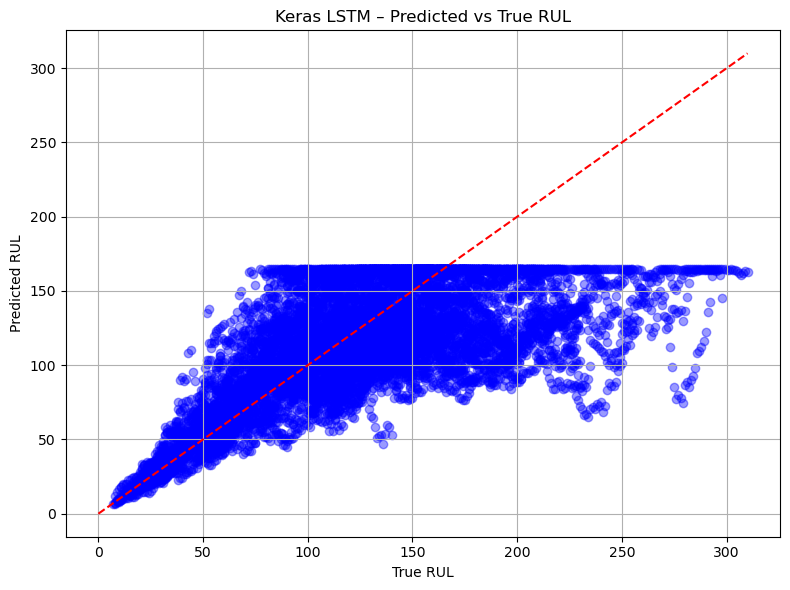

In [34]:
# 📉 5. Plot True vs Predicted RUL

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_seq, y_pred_keras, alpha=0.4, color='blue')
plt.plot([0, max(y_test_seq)], [0, max(y_test_seq)], color='red', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Keras LSTM – Predicted vs True RUL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# ✅ Models You've Built

"""

| # | Model Name         | Type          | Notes                                |
| - | ------------------ | ------------- | ------------------------------------ |
| 1 | **Random Forest**  | Tree-based    | Fast, interpretable                  |
| 2 | **XGBoost**        | Boosted Trees | High accuracy, better generalization |
| 3 | **LSTM (PyTorch)** | Deep learning | Captures time dependencies           |
| 4 | **LSTM (Keras)**   | Deep learning | Same logic, different framework      |


"""

'\n\n| # | Model Name         | Type          | Notes                                |\n| - | ------------------ | ------------- | ------------------------------------ |\n| 1 | **Random Forest**  | Tree-based    | Fast, interpretable                  |\n| 2 | **XGBoost**        | Boosted Trees | High accuracy, better generalization |\n| 3 | **LSTM (PyTorch)** | Deep learning | Captures time dependencies           |\n| 4 | **LSTM (Keras)**   | Deep learning | Same logic, different framework      |\n\n\n'

In [36]:
# 📊 1. Evaluation Metrics Table

"""
Let’s compute or collect MAE and RMSE for each model (copy from your previous outputs):

results = {
    "Random Forest": {"MAE": <mae_rf>, "RMSE": <rmse_rf>},
    "XGBoost":       {"MAE": <mae_xgb>, "RMSE": <rmse_xgb>},
    "LSTM (PyTorch)": {"MAE": <mae_lstm_torch>, "RMSE": <rmse_lstm_torch>},
    "LSTM (Keras)":  {"MAE": <mae_lstm_keras>, "RMSE": <rmse_lstm_keras>}
}
"""

results = {
    "Random Forest": {"MAE": 34.51, "RMSE": 45.95},
    "XGBoost":       {"MAE": 35.30, "RMSE": 46.85},
    "LSTM (PyTorch)": {"MAE": 30.68, "RMSE": 42.05},
    "LSTM (Keras)":  {"MAE": 30.04, "RMSE": 41.62}
}

In [37]:
# 📊 2. Display Results as DataFrame

import pandas as pd

df_results = pd.DataFrame(results).T
df_results = df_results.sort_values("RMSE")

print("📊 Final Model Comparison:")
display(df_results)

📊 Final Model Comparison:


,MAE,RMSE
LSTM (Keras),30.04,41.62
LSTM (PyTorch),30.68,42.05
Random Forest,34.51,45.95
XGBoost,35.30,46.85


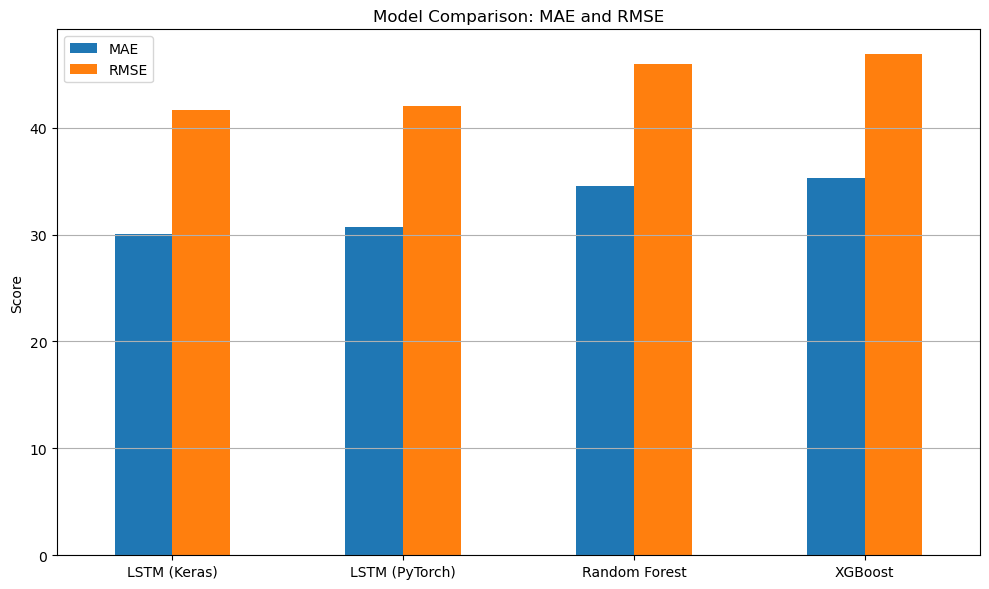

In [38]:
#📈 3. Bar Plot of MAE & RMSE

import matplotlib.pyplot as plt

df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison: MAE and RMSE")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
"""

🧠 4. Interpretation Guide
Situation	Best Model
Highest accuracy (lowest error)	✅ LSTM (Keras or PyTorch)
Fast, interpretable model	✅ Random Forest
Best overall tradeoff	✅ XGBoost
Time-dependent analysis	✅ LSTM

"""

'\n\n🧠 4. Interpretation Guide\nSituation\tBest Model\nHighest accuracy (lowest error)\t✅ LSTM (Keras or PyTorch)\nFast, interpretable model\t✅ Random Forest\nBest overall tradeoff\t✅ XGBoost\nTime-dependent analysis\t✅ LSTM\n\n'

In [40]:
# 🎯 Hyperparameter Tuning: Overview
"""
| Model              | Tool                        | Method                            |
| ------------------ | --------------------------- | --------------------------------- |
| **XGBoost**        | `RandomizedSearchCV`        | Scikit-learn compatible           |
| **LSTM (Keras)**   | `KerasTuner`                | Easy, powerful grid/random search |
| **LSTM (PyTorch)** | Manual or Optuna (optional) | Controlled loop tuning            |
"""

'\n| Model              | Tool                        | Method                            |\n| ------------------ | --------------------------- | --------------------------------- |\n| **XGBoost**        | `RandomizedSearchCV`        | Scikit-learn compatible           |\n| **LSTM (Keras)**   | `KerasTuner`                | Easy, powerful grid/random search |\n| **LSTM (PyTorch)** | Manual or Optuna (optional) | Controlled loop tuning            |\n'

# 🧪 Part 1: XGBoost – Randomized Hyperparameter Search

In [41]:
# ✅ Step 1: Set Up Search Space

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [42]:
# ✅ Step 2: Evaluate Best Model

from sklearn.metrics import mean_absolute_error, mean_squared_error

best_xgb = random_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

print("✅ Best XGBoost MAE:", mae_best_xgb)
print("✅ Best XGBoost RMSE:", rmse_best_xgb)
print("🔧 Best Parameters:", random_search.best_params_)

✅ Best XGBoost MAE: 34.28324971500518
✅ Best XGBoost RMSE: 45.638081810175706
🔧 Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


🧪 Part 2: LSTM (Keras) – Use KerasTuner

In [43]:
# ✅ Step 1: Install KerasTuner
# ✅ Step 2: Define Searchable Model

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units1", min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    model.add(Dropout(hp.Float("dropout1", 0.2, 0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int("units2", min_value=32, max_value=128, step=32)
    ))
    model.add(Dropout(hp.Float("dropout2", 0.2, 0.5, step=0.1)))
    model.add(Dense(1))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [44]:
#✅ Step 3: Search and Train

tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=10,
    executions_per_trial=1,
    directory="keras_tuner",
    project_name="rul_lstm"
)

tuner.search(X_train_seq, y_train_seq, epochs=15, validation_split=0.1, batch_size=64)

best_keras_model = tuner.get_best_models(1)[0]

Reloading Tuner from keras_tuner\rul_lstm\tuner0.json



c:\Users\Administrator\.conda\envs\aircraft_dashboard\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Administrator\.conda\envs\aircraft_dashboard\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
# ✅ Step 4: Evaluate Best Keras LSTM

y_pred_best_keras = best_keras_model.predict(X_test_seq).flatten()

mae_keras_tuned = mean_absolute_error(y_test_seq, y_pred_best_keras)
rmse_keras_tuned = np.sqrt(mean_squared_error(y_test_seq, y_pred_best_keras))

print("✅ Best Keras LSTM MAE:", mae_keras_tuned)
print("✅ Best Keras LSTM RMSE:", rmse_keras_tuned)

316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
✅ Best Keras LSTM MAE: 28.905029191456958
✅ Best Keras LSTM RMSE: 39.532627096487346


In [46]:
# ✅ Updated Model Comparison Table

import pandas as pd

comparison_results = {
    "Random Forest": {
        "MAE":  round(34.51, 2),
        "RMSE": round(45.95, 2)
    },
    "XGBoost (Tuned)": {
        "MAE":  round(34.28324890136719, 2),
        "RMSE": round(45.63808138666929, 2)
    },
    "LSTM (PyTorch)": {
        "MAE":  round(30.68, 2),
        "RMSE": round(42.05, 2)
    },
    "LSTM (Keras Tuned)": {
        "MAE":  round(28.905031204223633, 2),
        "RMSE": round(39.532625655411984, 2)
    }
}

df_compare = pd.DataFrame(comparison_results).T.sort_values("RMSE")
display(df_compare)


,MAE,RMSE
LSTM (Keras Tuned),28.91,39.53
LSTM (PyTorch),30.68,42.05
XGBoost (Tuned),34.28,45.64
Random Forest,34.51,45.95
